In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random

In [78]:
tf.random.set_seed(42)

# **Dowload dataset and extract it**

In [79]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-07-17 19:57:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   290MB/s    in 1.7s    

2022-07-17 19:57:31 (290 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [80]:
import zipfile

zip_ref = zipfile.ZipFile("/content/10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

# **Look into directory size and structure**

In [81]:
import os

for dpath, dname, fname in os.walk("/content/10_food_classes_all_data"):
  print(f"There are {len(dname)} directories and {len(fname)} images in '{dpath}'.")

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/test'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_all_data/test/

# **Extracting Class Names**

In [82]:
import pathlib

path = pathlib.Path("/content/10_food_classes_all_data/train")

class_names = list(sorted(item.name for item in path.glob('*')))
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# **Visualise Random Samples**

In [83]:
def view_random_sample(target_dir, target_class):
  target_path = target_dir + "/" + target_class
  image = random.sample(os.listdir(target_path), 1)
  #print(image)
  img = plt.imread(target_path + "/" + image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

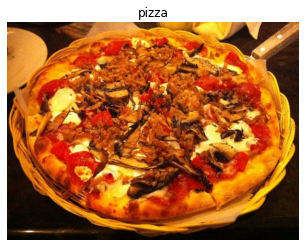

In [84]:
view_random_sample("/content/10_food_classes_all_data/train/", "pizza")

# **View many samples at once**

In [85]:
def view_multiple_samples(target_dir, n):
  plt.figure(figsize=(30,17))
  index = 31
  for i in range(1, n+1):
    plt.subplot(1, n, i)
    target_class = class_names[index%10]
    view_random_sample(target_dir, target_class)
    index = index+1

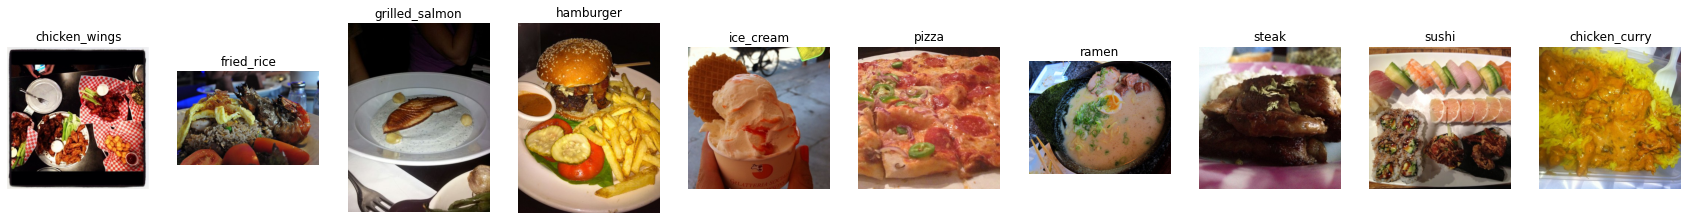

In [86]:
view_multiple_samples("/content/10_food_classes_all_data/train/", 10)

# **Preprocessing Data**

In [87]:
from tensorflow.python.ops.gen_batch_ops import batch
train_datagen = ImageDataGenerator(rescale=1/255.)

valid_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "/content/10_food_classes_all_data/train"
test_dir = "/content/10_food_classes_all_data/test"

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical",
                                               shuffle=True)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical",
                                               shuffle=True)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# **Let's extract features from EfficientNet model from tfhub**

In [88]:
import tensorflow_hub as hub
efficientnet_model_feature = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                                            input_shape=(224,224,3),
                                            trainable=False,
                                            name = "EfficientNet")

# **Build the model**

In [89]:
model = tf.keras.Sequential([
  efficientnet_model_feature,
  tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(train_data,
          epochs = 5,
          steps_per_epoch = len(train_data),
          validation_data = valid_data,
          validation_steps = len(valid_data))

Epoch 1/5
235/235 [==============================] - 59s 209ms/step - loss: 0.8154 - accuracy: 0.7693 - val_loss: 0.3997 - val_accuracy: 0.8924
Epoch 2/5
235/235 [==============================] - 50s 215ms/step - loss: 0.4468 - accuracy: 0.8656 - val_loss: 0.3282 - val_accuracy: 0.9056
Epoch 3/5
235/235 [==============================] - 49s 210ms/step - loss: 0.3723 - accuracy: 0.8883 - val_loss: 0.3022 - val_accuracy: 0.9116
Epoch 4/5
235/235 [==============================] - 49s 210ms/step - loss: 0.3290 - accuracy: 0.9013 - val_loss: 0.2855 - val_accuracy: 0.9140
Epoch 5/5
235/235 [==============================] - 49s 207ms/step - loss: 0.2970 - accuracy: 0.9128 - val_loss: 0.2774 - val_accuracy: 0.9180


# **Plotting Loss Curves**

In [90]:
def plot_loss_curves(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(len(history.history["loss"]))
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.xlabel("epochs")
  plt.title("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.xlabel("epochs")
  plt.title("Accuracy")
  plt.legend()


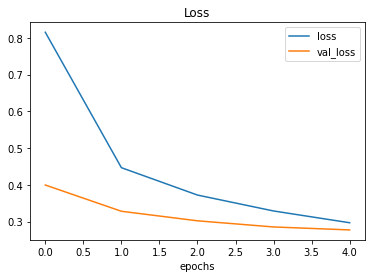

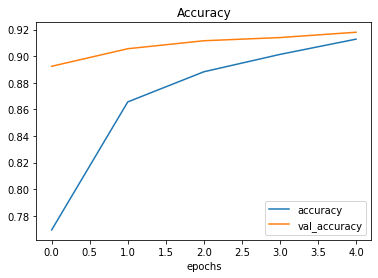

In [91]:
plot_loss_curves(history)

# **Let's load and prepare a custom image**

In [92]:
def load_and_prep(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img)

  img = tf.image.resize(img, size=[224,224])
  img = img/ 255.
  return img

# **Let's predict on a custom image**

In [109]:
def pred_and_plot(model, image_path):
  img = load_and_prep(image_path)

  pred = model.predict(tf.expand_dims(img, axis=0))

  pred_label = class_names[tf.argmax(pred[0])]

  print(f"The predicted class is {pred_label}")

  plt.imshow(img)
  plt.title(pred_label)
  plt.axis(False)
  return pred_label



In [94]:
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [95]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2022-07-17 20:02:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1725178 (1.6M) [image/jpeg]
Saving to: ‘03-sushi.jpeg.1’

03-sushi.jpeg.1     100%[===================>]   1.64M  --.-KB/s    in 0.06s   

2022-07-17 20:02:58 (29.1 MB/s) - ‘03-sushi.jpeg.1’ saved [1725178/1725178]



The predicted class is sushi


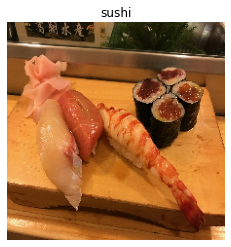

In [96]:
pred_and_plot("03-sushi.jpeg")

# **Hurrah!!!!!!!!!!!!!**

In [97]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

--2022-07-17 20:03:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg.1’

03-hamburger.jpeg.1 100%[===================>]   3.40M  --.-KB/s    in 0.06s   

2022-07-17 20:03:00 (53.0 MB/s) - ‘03-hamburger.jpeg.1’ saved [3564285/3564285]



The predicted class is hamburger


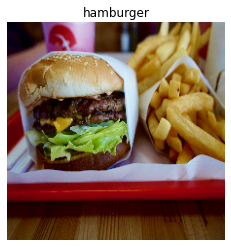

In [98]:
pred_and_plot("03-hamburger.jpeg")

In [99]:
model.save("FoodVision10.h5")

# **Creating a WebApp**

In [101]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
print("Completed!")

Completed!


In [102]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

--2022-07-17 20:14:41--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13770165 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz’

ngrok-stable-linux- 100%[===================>]  13.13M  5.21MB/s    in 2.5s    

2022-07-17 20:14:44 (5.21 MB/s) - ‘ngrok-stable-linux-amd64.tgz’ saved [13770165/13770165]



In [103]:
!tar -xvf /content/ngrok-stable-linux-amd64.tgz

ngrok


In [104]:
!./ngrok authtoken 2BxTTMN1iLbyEs5lsY6qtcGrSAd_7xYngAGdEtRozKR1Yg7ih

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok



app = Flask(__name__)
run_with_ngrok(app)

#model1 = tf.keras.models.load_model('/content/FoodVision10.h5')

model2 = tf.keras.models.load_model(
       ('/content/FoodVision10.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

	
# routes
@app.route("/", methods=['GET', 'POST'])
def main():
  #return "Hello World"
	return render_template("index.html")

@app.route("/submit", methods = ['GET', 'POST'])
def get_output():
	if request.method == 'POST':
		img = request.files['my_image']

		img_path = "static/" + img.filename	
		img.save(img_path)

		p = pred_and_plot(model2, img_path)
	return render_template("index.html", prediction = p, img_path = img_path)
  

if __name__ =='__main__':
	app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://d5ae-34-67-34-135.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:37:04] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:37:04] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:37:15] "POST /submit HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:37:15] "GET /static/ramen1.jpeg HTTP/1.1" 200 -


The predicted class is ramen


INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:39:41] "POST /submit HTTP/1.1" 200 -


The predicted class is ice_cream


INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:39:41] "GET /static/icecream.jpeg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:44:18] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:45:01] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:45:03] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:47:43] "POST /submit HTTP/1.1" 200 -


The predicted class is sushi


INFO:werkzeug:127.0.0.1 - - [17/Jul/2022 20:47:43] "GET /static/images.jpeg.jpg HTTP/1.1" 200 -
